In [20]:
import pandas as pd
import numpy as np
import ta
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE


def fin_model_3(df, param_grid=None):
    """
    Voegt candlestick-gebaseerde signalen toe aan de originele dataset en voorspelt marktrichting.

    Args:
    df (pd.DataFrame): De originele dataset.
    param_grid (dict): Parameter grid voor modeloptimalisatie.

    Returns:
    pd.DataFrame: De originele dataset met 'Signal_fin_model_3' en 'Probability_fin_model_3'.
    """
    # Reset index en verwerk data
    if df.index.name == 'Date' or isinstance(df.index, pd.DatetimeIndex):
        df = df.reset_index()

    # Vereiste kolommen
    df2 = df[['Date', 'Close', 'High', 'Low', 'Open', 'Volume']].copy()
    df2 = df2[df2.High != df2.Low]
    df2.reset_index(inplace=True, drop=True)

    # Bereken candle-attributen
    df2['body_size'] = abs(df2['Close'] - df2['Open'])  # Grootte van de candle body
    df2['upper_wick'] = df2['High'] - np.maximum(df2['Close'], df2['Open'])
    df2['lower_wick'] = np.minimum(df2['Close'], df2['Open']) - df2['Low']
    df2['candle_ratio'] = df2['body_size'] / (df2['High'] - df2['Low'])  # Relatieve grootte van de body

    # Voeg een ATR-indicator toe
    df2['atr'] = ta.volatility.average_true_range(high=df2['High'], low=df2['Low'], close=df2['Close'], window=14)

    # Candlestick signalen
    df2['Signal_fin_model_3'] = 0

    for i in range(1, len(df2)):
        # Bullish engulfing pattern
        if (df2['Close'].iloc[i] > df2['Open'].iloc[i] and
            df2['Close'].iloc[i - 1] < df2['Open'].iloc[i - 1] and
            df2['Close'].iloc[i] > df2['Open'].iloc[i - 1] and
            df2['Open'].iloc[i] < df2['Close'].iloc[i - 1]):
            df2.at[i, 'Signal_fin_model_3'] = 1  # Koopsignaal

        # Bearish engulfing pattern
        elif (df2['Close'].iloc[i] < df2['Open'].iloc[i] and
              df2['Close'].iloc[i - 1] > df2['Open'].iloc[i - 1] and
              df2['Close'].iloc[i] < df2['Open'].iloc[i - 1] and
              df2['Open'].iloc[i] > df2['Close'].iloc[i - 1]):
            df2.at[i, 'Signal_fin_model_3'] = -1  # Verkoopsignaal

        # Hammer pattern
        elif (df2['body_size'].iloc[i] < df2['lower_wick'].iloc[i] and
              df2['upper_wick'].iloc[i] < 0.3 * df2['lower_wick'].iloc[i]):
            df2.at[i, 'Signal_fin_model_3'] = 1  # Koopsignaal

        # Shooting star pattern
        elif (df2['body_size'].iloc[i] < df2['upper_wick'].iloc[i] and
              df2['lower_wick'].iloc[i] < 0.3 * df2['upper_wick'].iloc[i]):
            df2.at[i, 'Signal_fin_model_3'] = -1  # Verkoopsignaal

    # Bereid de data voor machine learning
    df2 = df2.dropna()
    feature_columns = ['Close', 'High', 'Low', 'Open', 'Volume', 'body_size', 'upper_wick', 'lower_wick', 'atr']
    X = df2[feature_columns]
    y = df2['Signal_fin_model_3']

    # Schalen en balanceren
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    sm = SMOTE(random_state=42)
    X_balanced, y_balanced = sm.fit_resample(X_scaled, y)

    # Modeloptimalisatie
    model = RandomForestClassifier(random_state=42)
    if param_grid is None:
        param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10]}

    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc')
    grid_search.fit(X_balanced, y_balanced)

    # Calibreer het model en bereken probabiliteiten
    calibrated_model = CalibratedClassifierCV(grid_search.best_estimator_, method='sigmoid', cv=3)
    calibrated_model.fit(X_balanced, y_balanced)

    probabilities = calibrated_model.predict_proba(X_scaled)[:, 1]

    # Voeg de berekende kolommen toe aan df2
    df2['Probability_fin_model_3'] = probabilities

    # Combineer de resultaten terug met de originele dataset
    df = df.merge(
        df2[['Date', 'Signal_fin_model_3', 'Probability_fin_model_3']],
        on='Date',
        how='left'
    )

    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.set_index('Date', inplace=True)

    return df, X_balanced, y_balanced, grid_search


In [21]:
df = pd.read_csv('end_set.csv')
df

,Date,Adj Close,Close,High,Low,Open,Volume,Change,Target,MA_5,...,Technology,Energy,Financials,Healthcare,10Yr_Treasury_Rate,Linear_model,Signal_fin_model_1,Probability_fin_model_1,Signal_fin_model_2,Probability_fin_model_2
0,2012-01-17,102.550842,129.339996,130.320007,128.899994,130.080002,132209200,0.003881,1,129.203998,...,26.200001,69.930000,11.137287,35.650002,1.850,109.566493,0.0,0.096458,0.0,0.001959
1,2012-01-18,103.684669,130.770004,130.839996,129.080002,129.309998,163395200,0.011056,1,129.531998,...,26.580000,71.080002,11.307880,35.849998,1.897,109.682186,0.0,0.092428,0.0,0.001959
2,2012-01-19,104.231796,131.460007,131.570007,130.800003,131.220001,126328900,0.005276,1,129.984000,...,26.770000,71.370003,11.413485,35.849998,1.972,109.797880,0.0,0.056295,0.0,0.001959
3,2012-01-20,104.620262,131.949997,131.949997,130.919998,131.240005,138230200,0.003727,1,130.472000,...,26.799999,71.379997,11.486596,35.849998,2.028,109.913573,0.0,0.055630,0.0,0.001959
4,2012-01-23,104.350677,131.610001,132.250000,130.979996,131.509995,129295800,-0.002577,0,131.026001,...,26.889999,71.949997,11.527214,35.689999,2.067,110.029267,0.0,0.057588,0.0,0.001959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3240,2024-12-03,603.909973,603.909973,604.159973,602.340027,603.390015,26906600,0.000464,1,601.914001,...,236.800003,94.510002,50.450001,146.820007,4.223,484.529218,0.0,0.106271,1.0,0.908615
3241,2024-12-04,607.659973,607.659973,607.909973,604.950012,605.630005,42787600,0.006210,1,603.315991,...,241.130005,92.230003,50.259998,146.740005,4.180,484.644911,0.0,0.091987,1.0,0.908615
3242,2024-12-05,606.659973,606.659973,608.479980,606.299988,607.659973,28762200,-0.001646,0,604.881982,...,239.910004,92.589996,50.410000,145.100006,4.180,484.760605,0.0,0.095634,1.0,0.908615
3243,2024-12-06,607.809998,607.809998,609.070007,607.020020,607.440002,31241500,0.001896,1,605.933984,...,240.839996,91.019997,50.400002,144.279999,4.151,484.876298,0.0,0.090502,1.0,0.908615


In [22]:
# df.reset_index(inplace=True)

# Voer fin_model_3 uit
df, X_balanced, y_balanced, grid_search = fin_model_3(df)

# Bekijk resultaten
df

c:\Users\DCG13\Documents\Alpaca\trading1_env\lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\DCG13\Documents\Alpaca\trading1_env\lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\DCG13\Documents\Alpaca\trading1_env\lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "c:\Users\DCG13\Documents\Alpaca\trading1_env\lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\DCG13\Documents\Alpaca\trading1_env\lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return fu

,Adj Close,Close,High,Low,Open,Volume,Change,Target,MA_5,MA_10,...,Financials,Healthcare,10Yr_Treasury_Rate,Linear_model,Signal_fin_model_1,Probability_fin_model_1,Signal_fin_model_2,Probability_fin_model_2,Signal_fin_model_3,Probability_fin_model_3
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-17,102.550842,129.339996,130.320007,128.899994,130.080002,132209200,0.003881,1,129.203998,128.498998,...,11.137287,35.650002,1.850,109.566493,0.0,0.096458,0.0,0.001959,0,0.338131
2012-01-18,103.684669,130.770004,130.839996,129.080002,129.309998,163395200,0.011056,1,129.531998,128.825999,...,11.307880,35.849998,1.897,109.682186,0.0,0.092428,0.0,0.001959,1,0.192702
2012-01-19,104.231796,131.460007,131.570007,130.800003,131.220001,126328900,0.005276,1,129.984000,129.202000,...,11.413485,35.849998,1.972,109.797880,0.0,0.056295,0.0,0.001959,1,0.209448
2012-01-20,104.620262,131.949997,131.949997,130.919998,131.240005,138230200,0.003727,1,130.472000,129.593000,...,11.486596,35.849998,2.028,109.913573,0.0,0.055630,0.0,0.001959,0,0.341153
2012-01-23,104.350677,131.610001,132.250000,130.979996,131.509995,129295800,-0.002577,0,131.026001,129.983000,...,11.527214,35.689999,2.067,110.029267,0.0,0.057588,0.0,0.001959,0,0.384317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-03,603.909973,603.909973,604.159973,602.340027,603.390015,26906600,0.000464,1,601.914001,597.708002,...,50.450001,146.820007,4.223,484.529218,0.0,0.106271,1.0,0.908615,1,0.339955
2024-12-04,607.659973,607.659973,607.909973,604.950012,605.630005,42787600,0.006210,1,603.315991,599.444000,...,50.259998,146.740005,4.180,484.644911,0.0,0.091987,1.0,0.908615,0,0.690973
2024-12-05,606.659973,606.659973,608.479980,606.299988,607.659973,28762200,-0.001646,0,604.881982,601.059998,...,50.410000,145.100006,4.180,484.760605,0.0,0.095634,1.0,0.908615,0,0.702463


In [24]:
df['Signal_fin_model_3'].value_counts()

Signal_fin_model_3
 0    2382
 1     525
-1     338
Name: count, dtype: int64

In [26]:
print(df.index.name)  # Controleer de naam van de index


Date


In [27]:
df.reset_index(inplace=True)

bearish_signals = df[df['Signal_fin_model_3'] == -1]
print(bearish_signals[['Date', 'Open', 'High', 'Low', 'Close', 'Signal_fin_model_3']].head(10))


         Date        Open        High         Low       Close  \
11 2012-02-01  132.289993  133.139999  132.130005  132.470001   
21 2012-02-15  135.630005  135.830002  134.289993  134.559998   
30 2012-02-29  137.759995  138.190002  136.539993  137.020004   
56 2012-04-05  139.380005  140.199997  139.259995  139.789993   
57 2012-04-09  138.029999  139.839996  137.839996  138.220001   
64 2012-04-18  138.460007  139.080002  138.380005  138.610001   
65 2012-04-19  138.630005  139.149994  137.070007  137.720001   
66 2012-04-20  138.330002  138.830002  137.869995  137.949997   
75 2012-05-03  140.339996  140.449997  138.990005  139.250000   
81 2012-05-11  135.169998  136.869995  135.110001  135.610001   

    Signal_fin_model_3  
11                  -1  
21                  -1  
30                  -1  
56                  -1  
57                  -1  
64                  -1  
65                  -1  
66                  -1  
75                  -1  
81                  -1  


Accuracy: 0.8825

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.88      0.89       483
           0       0.80      0.88      0.84       483
           1       0.96      0.89      0.92       464

    accuracy                           0.88      1430
   macro avg       0.89      0.88      0.88      1430
weighted avg       0.89      0.88      0.88      1430



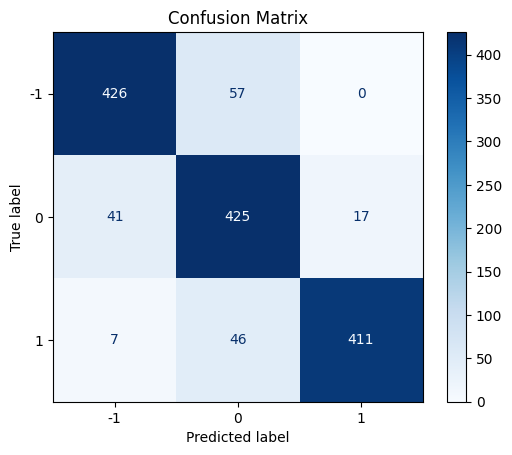

ValueError: multiclass format is not supported

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Splits de gebalanceerde data in training- en testsets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Gebruik het beste model van het GridSearch
best_model = grid_search.best_estimator_

# Train het model op de trainingsset
best_model.fit(X_train, y_train)

# Maak voorspellingen op de testset
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probabiliteiten voor ROC-curve

# Evaluatie 1: Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Evaluatie 2: Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Evaluatie 3: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Evaluatie 4: ROC-curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()
